<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Aprendizado

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# from sklearn.model_selection import GridSearchCV

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEMENTE = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'

## Hiperparâmetros TensorFlow

In [3]:
LOTE_TAMANHO = 1024

CAMADAS = 4

CAMADA_UNIDADES      = 50
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

## Funções

In [4]:
def avaliar_previsoes(alvos, previsoes):

    print(classification_report(alvos, previsoes))

    ConfusionMatrixDisplay.from_predictions(alvos, previsoes, values_format='d', cmap=PALETA)
    plt.grid(False)

    relatorio = classification_report(alvos, previsoes, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def obter_conjunto(dados_treino, dados_validacao, q_modelos=10):

    conjunto = []

    for m in range(q_modelos):

        print(f'Modelo {m} de {q_modelos}.')

        modelo = Sequential()

        [modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
        modelo.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

        modelo.compile(loss=PERDA,
                       optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                       metrics=METRICAS)

        modelo.fit(dados_treino,
                   epochs=ITERACOES,
                   validation_data=dados_validacao,
                   verbose=0)
        
        conjunto.append(modelo)

    return conjunto

def obter_previsoes(conjunto, dados_validacao):
    
    previsoes = []

    for modelo in conjunto:
        previsoes.append(modelo.predict(dados_validacao, verbose=0))
    
    return tf.constant(tf.squeeze(previsoes))

# Dados

In [5]:
df_sintomas = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas.zip')

## Separação dos dados de treino e teste

In [6]:
X = df_sintomas.drop('EVOLUCAO', axis=1)
y = df_sintomas['EVOLUCAO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Datasets

In [7]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Aprendizado

## Classificação sobre sintomas e fatores de risco, com EVOLUCAO como atributo alvo

In [8]:
sintomas_evolucao_avaliacoes = [None] * 10

### Modelo 0: SKLearn Decision Tree

In [9]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# param_grid = {'param': np.linspace(99, 99, 99, dtype='int'),
#               'param': ['value', 'value']}

# grid = GridSearchCV(estimator=dtc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 4.35 s, sys: 56 ms, total: 4.4 s
Wall time: 6.95 s


              precision    recall  f1-score   support

           0       0.44      0.21      0.28     16796
           1       0.70      0.87      0.78     36185

    accuracy                           0.66     52981
   macro avg       0.57      0.54      0.53     52981
weighted avg       0.62      0.66      0.62     52981



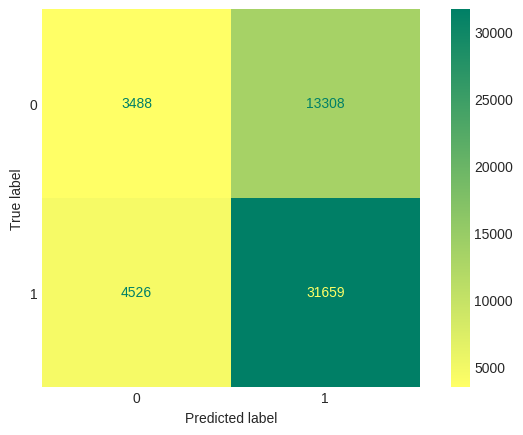

In [10]:
sintomas_evolucao_avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

### Modelo 1: SKLearn Random Forest

In [11]:
%%time

rfc = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

CPU times: user 45.1 s, sys: 333 ms, total: 45.4 s
Wall time: 49.4 s


              precision    recall  f1-score   support

           0       0.47      0.18      0.26     16796
           1       0.70      0.91      0.79     36185

    accuracy                           0.67     52981
   macro avg       0.58      0.54      0.52     52981
weighted avg       0.63      0.67      0.62     52981



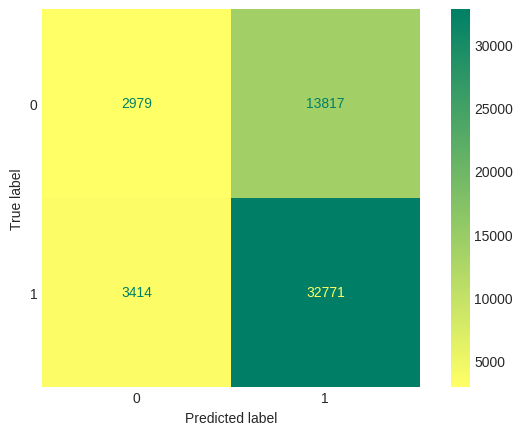

In [12]:
sintomas_evolucao_avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

### Modelo 2: SKLearn AdaBoost

In [13]:
%%time

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 18.7 s, sys: 1.07 s, total: 19.8 s
Wall time: 19.7 s


              precision    recall  f1-score   support

           0       0.54      0.10      0.16     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.62      0.53      0.49     52981
weighted avg       0.65      0.69      0.60     52981



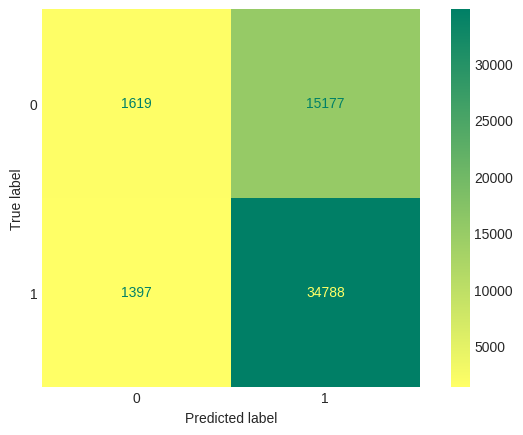

In [14]:
sintomas_evolucao_avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

### Modelo 3: SKLearn Gradient Boosting

In [15]:
%%time

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 35.1 s, sys: 91.3 ms, total: 35.2 s
Wall time: 35.1 s


              precision    recall  f1-score   support

           0       0.56      0.12      0.19     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.63      0.54      0.50     52981
weighted avg       0.65      0.69      0.61     52981



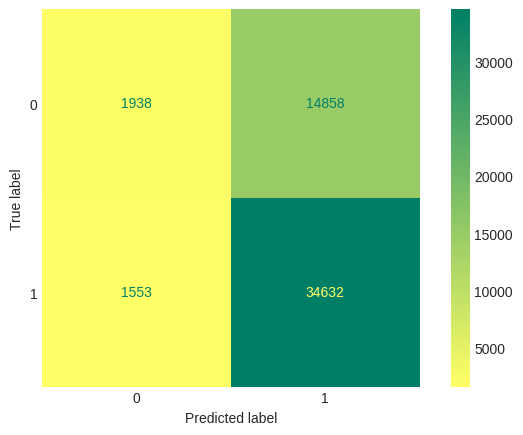

In [16]:
sintomas_evolucao_avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

### Modelo 4: XGBoost

In [17]:
%%time

xgb = XGBClassifier(n_estimators=50, grow_policy='depthwise', learning_rate=0.5, random_state=SEMENTE)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 1min 5s, sys: 231 ms, total: 1min 5s
Wall time: 40.5 s


              precision    recall  f1-score   support

           0       0.54      0.13      0.21     16796
           1       0.70      0.95      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.62      0.54      0.51     52981
weighted avg       0.65      0.69      0.62     52981



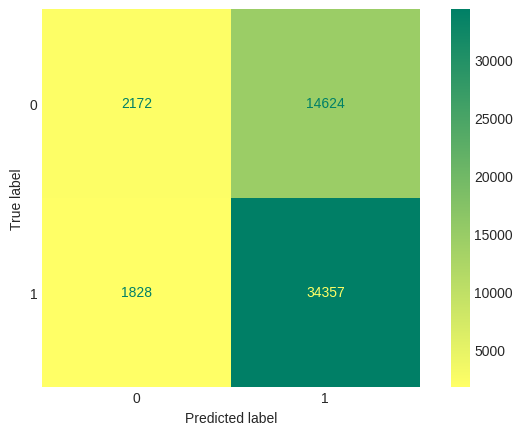

In [18]:
sintomas_evolucao_avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

### Modelo 5: TensorFlow Dense

In [19]:
%%time

tf.random.set_seed(SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 4min 36s, sys: 9.67 s, total: 4min 45s
Wall time: 3min 6s


              precision    recall  f1-score   support

           0       0.53      0.11      0.18     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.62      0.53      0.49     52981
weighted avg       0.65      0.69      0.61     52981



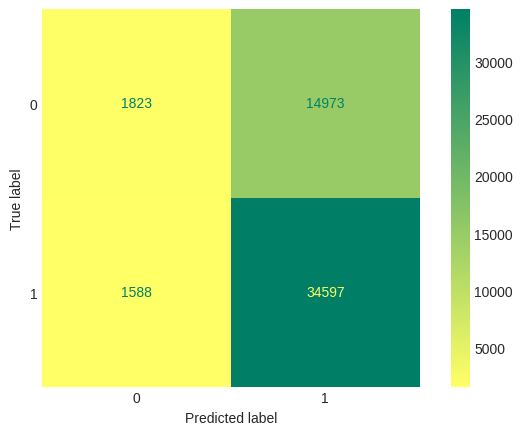

In [20]:
sintomas_evolucao_avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

### Modelo 6: TensorFlow Profound

In [32]:
%%time

tf.random.set_seed(SEMENTE)

tfp = Sequential()

[tfp.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS ** 3)]
tfp.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfp.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfp.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfp.predict(dataset_test, verbose=0))

CPU times: user 12min 45s, sys: 12.4 s, total: 12min 58s
Wall time: 10min 54s


              precision    recall  f1-score   support

           0       0.53      0.11      0.18     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.61      0.53      0.49     52981
weighted avg       0.64      0.69      0.61     52981



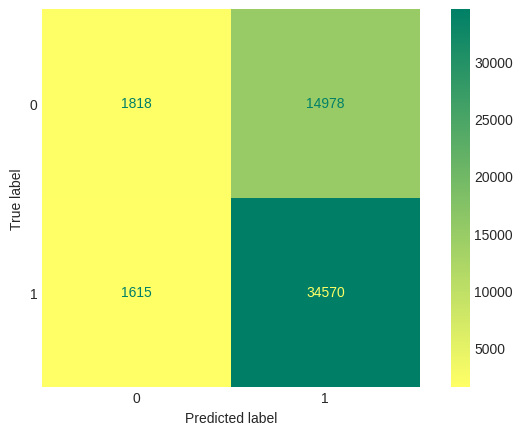

In [33]:
sintomas_evolucao_avaliacoes[6] = avaliar_previsoes(y_test, y_pred)

### Modelo 7: TensorFlow Ensemble

In [23]:
%%time

conjunto = obter_conjunto(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=5)

Modelo 0 de 5.
Modelo 1 de 5.
Modelo 2 de 5.
Modelo 3 de 5.
Modelo 4 de 5.
CPU times: user 22min 28s, sys: 45 s, total: 23min 13s
Wall time: 14min 38s


In [24]:
previsoes = obter_previsoes(conjunto=conjunto, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.54      0.13      0.21     16796
           1       0.70      0.95      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.62      0.54      0.51     52981
weighted avg       0.65      0.69      0.62     52981



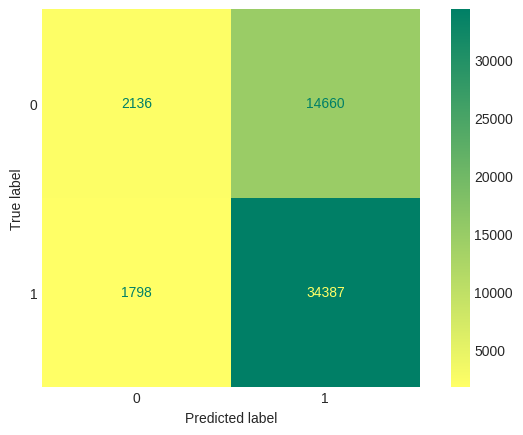

In [25]:
sintomas_evolucao_avaliacoes[7] = avaliar_previsoes(y_test, y_pred)

### Comparação de modelos

In [35]:
comparacao = pd.DataFrame([a for a in sintomas_evolucao_avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

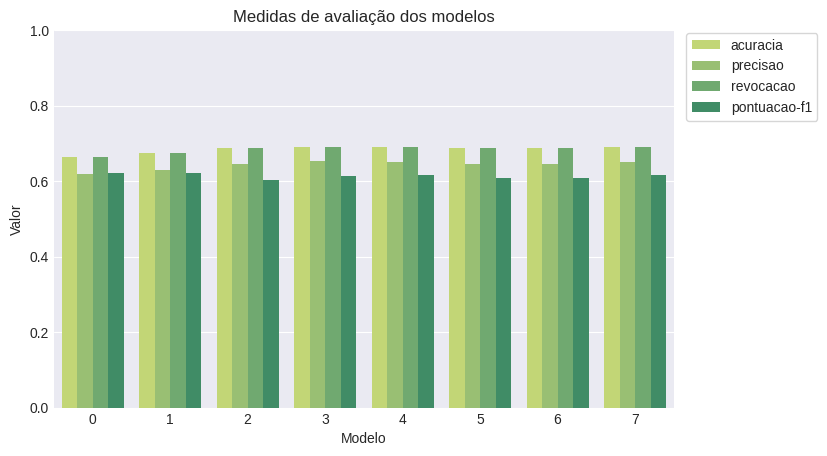

In [36]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.ylim(0, 1)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.legend(loc=(1.02, 0.76), frameon=True, facecolor='white');